In [30]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Configuration
DATA_PATH = "/Volumes/E/Projects/Data/Online Retail/OnlineRetail.csv"
OUTPUT_DIR = "data"
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "cleaned_data.csv")


In [5]:
print(f"Loading data from {DATA_PATH}...")

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH, encoding="ISO-8859-1")
print(f"Initial row count: {len(df)}")

df.head()

Loading data from /Volumes/E/Projects/Data/Online Retail/OnlineRetail.csv...
Initial row count: 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
country_counts = df['Country'].value_counts()
print(country_counts)

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


# Phase 1 – Data Quality Checks

In [6]:
# Negative Quantities
neg_qty = df[df['Quantity'] < 0]
print(f"Rows with Negative Quantity: {len(neg_qty)}")

# Null CustomerIDs
null_cust = df['CustomerID'].isnull().sum()
print(f"Rows with Null CustomerID: {null_cust}")

# Data Types
df.dtypes


Rows with Negative Quantity: 10624
Rows with Null CustomerID: 135080


InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

# Phase 2: Cleaning data

### Step 1: Filtering UK Data

In [7]:
df_uk = df[df['Country'] == 'United Kingdom'].copy()
print(f"Rows after filtering UK: {len(df_uk)}")

df_uk.head()


Rows after filtering UK: 495478


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Step 2: Eliminating Returns

In [9]:
df_clean = df_uk[~df_uk['InvoiceNo'].astype(str).str.startswith('C')].copy()
print(f"Rows after removing returns: {len(df_clean)}")


Rows after removing returns: 487622


### Step 3: Feature Engineering

In [10]:
df_clean['TotalSales'] = df_clean['Quantity'] * df_clean['UnitPrice']
df_clean[['Quantity', 'UnitPrice', 'TotalSales']].head()


,Quantity,UnitPrice,TotalSales
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


#####  -> Clean data

In [11]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

df_clean.to_csv(OUTPUT_FILE, index=False)
print(f"Saved cleaned data to {OUTPUT_FILE}")


Saved cleaned data to data/cleaned_data.csv


### Datetime Conversion

In [12]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

df_clean[['InvoiceDate']].head()


,InvoiceDate
0,2010-12-01 08:26:00
1,2010-12-01 08:26:00
2,2010-12-01 08:26:00
3,2010-12-01 08:26:00
4,2010-12-01 08:26:00


In [19]:
df_clean['InvoiceDate'].isna().sum()


np.int64(0)

# Phase 3: Analysis

### Analysis 1: Top 10 Bestselling Products

In [13]:
top_qty = (
    df_clean
    .groupby('Description')['Quantity']
    .sum()
    .nlargest(10)
)

top_qty


Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77036
WORLD WAR 2 GLIDERS ASSTD DESIGNS     49526
JUMBO BAG RED RETROSPOT               44268
WHITE HANGING HEART T-LIGHT HOLDER    35744
POPCORN HOLDER                        34738
ASSORTED COLOUR BIRD ORNAMENT         33735
PACK OF 12 LONDON TISSUES             25331
PACK OF 72 RETROSPOT CAKE CASES       24986
VICTORIAN GLASS HANGING T-LIGHT       23692
Name: Quantity, dtype: int64

### Analysis 2: Top 10 Revenue Products

In [14]:
top_revenue = (df_clean.groupby('Description')['TotalSales'].sum().nlargest(10))

top_revenue.apply(lambda x: f"${x:,.2f}")


Description
DOTCOM POSTAGE                        $206,248.77
PAPER CRAFT , LITTLE BIRDIE           $168,469.60
REGENCY CAKESTAND 3 TIER              $142,273.29
WHITE HANGING HEART T-LIGHT HOLDER    $100,497.72
PARTY BUNTING                          $93,658.53
JUMBO BAG RED RETROSPOT                $86,471.34
MEDIUM CERAMIC TOP STORAGE JAR         $80,575.63
PAPER CHAIN KIT 50'S CHRISTMAS         $62,742.54
ASSORTED COLOUR BIRD ORNAMENT          $54,756.79
CHILLI LIGHTS                          $53,336.56
Name: TotalSales, dtype: object

### Analysis 3: Sales by Hour

In [15]:
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

sales_by_hour = df_clean.groupby('Hour')['TotalSales'].sum()

sales_by_hour.apply(lambda x: f"${x:,.2f}")


Hour
6             $4.25
7        $11,124.58
8       $186,997.63
9       $823,542.29
10    $1,177,378.34
11    $1,032,975.87
12    $1,218,362.02
13    $1,061,984.84
14      $966,658.96
15    $1,197,352.50
16      $693,550.06
17      $429,023.02
18      $140,364.22
19       $44,846.62
20       $18,932.76
Name: TotalSales, dtype: object

### Analysis 4: Sales by Day of Week

In [16]:
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sales_by_day = (
    df_clean
    .groupby('DayOfWeek')['TotalSales']
    .sum()
    .reindex(days_order)
)

sales_by_day.apply(lambda x: f"${x:,.2f}")


DayOfWeek
Monday       $1,528,817.37
Tuesday      $1,885,586.86
Wednesday    $1,540,809.45
Thursday     $1,789,239.81
Friday       $1,543,816.22
Saturday              $nan
Sunday         $714,828.25
Name: TotalSales, dtype: object

# Phase 4: Visualization

In [ ]:
# 1. Enriching Data (Hourly)
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour


In [24]:
#2. Aggregation
hourly_sales = (df_clean.groupby('Hour', as_index=False)['TotalSales'].sum())
hourly_sales.head()


,Hour,TotalSales
0,6,4.250
1,7,11124.580
2,8,186997.630
3,9,823542.291
4,10,1177378.341


### Hourly Sales Analysis 

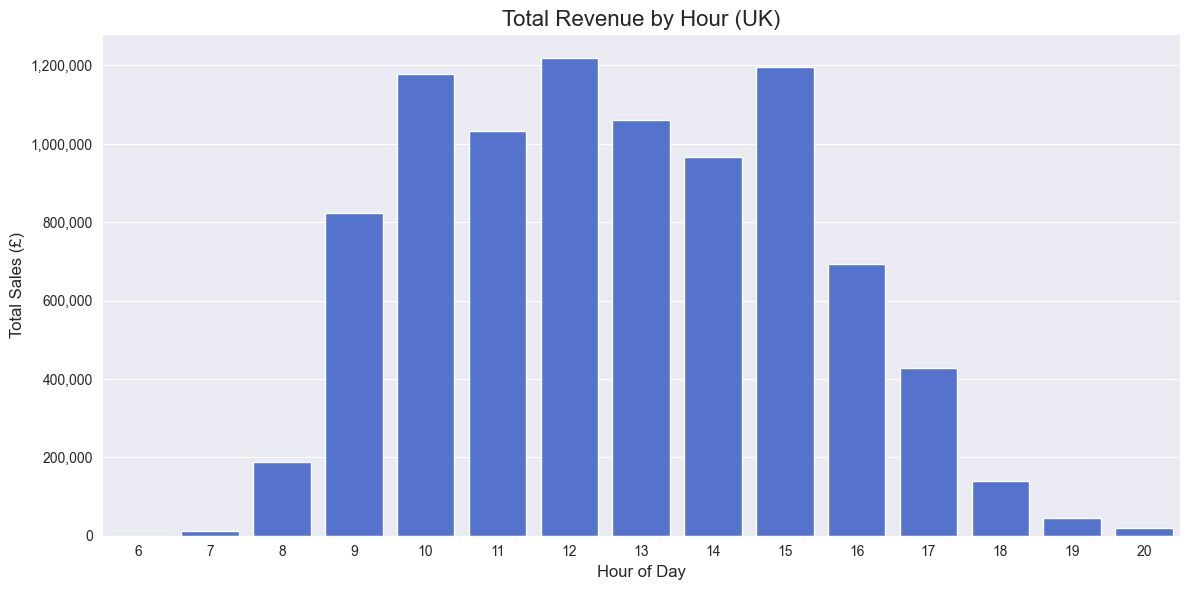

In [31]:
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

sns.barplot(
    data=hourly_sales,
    x='Hour',
    y='TotalSales',
    color='royalblue'
)

plt.title('Total Revenue by Hour (UK)', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Total Sales (£)', fontsize=12)

# Format Y-axis
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{x:,.0f}")
)

plt.tight_layout()
plt.show()


### Weekly Sales Analysis

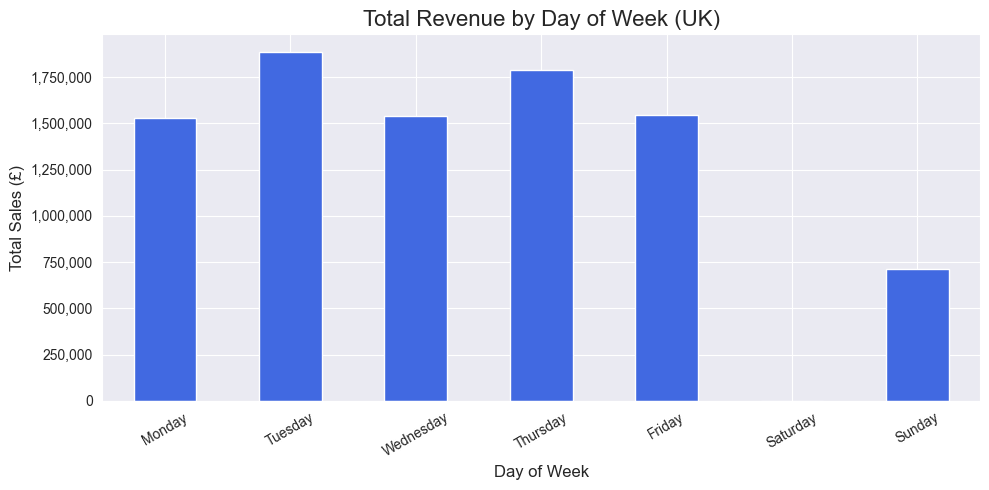

In [34]:
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")

sales_by_day.fillna(0).plot(
    kind='bar',
    color='royalblue'
)

plt.title('Total Revenue by Day of Week (UK)', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Sales (£)', fontsize=12)

# Format Y-axis
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{x:,.0f}")
)

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
